# Gaussian Process Regression (GPR)

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden

The aim of this notebook is to shortly show how one can construct a GPR over the space of the uncertain parameters in `UQit`. This is currently being done using [`GPyTorch`](https://docs.gpytorch.ai/en/v1.2.0/). So, one can directly look at the [`GPyTorch`](https://docs.gpytorch.ai/en/v1.2.0/) tutorial. 

In [1]:
import os
import sys
import numpy as np
import math as mt
from matplotlib import pyplot as plt
import torch
import gpytorch
from UQit.gpr_torch import gpr, gprPost, gprPlot
import UQit.analyticTestFuncs as analyticTestFuncs
import UQit.reshaper as reshaper
import UQit.sampling as sampling

### Example 1: Single-task GPR over a 1D parameter space

Consider the simulator $f(q)$ where $q\in \mathbb{Q}\subset \mathbb{R}$. The aim is to construct a GPR given a set of noisy training samples. In particular, we would like to observe the difference between the homoscedastic and heteroscedastic noises. 

First, we need a set of functions for generating synthetic training data:

In [2]:
def fEx(x):
    """Simulator"""
    yEx=np.sin(2*mt.pi*x)
    return yEx
def noiseGen(n,noiseType):
    """Generate a 1D numpy array of standard deviations of the observation noise"""
    if noiseType=='homo':
       sd=0.2   #standard deviation (Note: non-zero, to avoid instabilities)
       sdV=[sd]*n
       sdV=np.asarray(sdV)
    elif noiseType=='hetero':
       sdMin=0.05
       sdMax=0.55
       sdV=sdMin+(sdMax-sdMin)*np.linspace(0.0,1.0,n)
    return sdV
def trainData(xBound,n,noiseType):
    """Create training data D={X,Y}"""
    x=np.linspace(xBound[0],xBound[1],n)
    sdV=noiseGen(n,noiseType)
    y=fEx(x) + sdV * np.random.randn(n)
    return x,y,sdV

Different options for the GPR can be set as below. 

In [3]:
n=120           #number of training samples
nTest=100       #number of test samples
xBound=[0.,1]   #parameter range
#Type of the noise
noiseType='hetero'   #'homo'=homoscedastic, 'hetero'=heterscedastic
nIter_=800           #number of iterations in optimization of GPR hyperparameters
lr_   =0.1           #learning rate in the optimization of the hyperparameters
convPlot_=True       #plot convergence of optimization of the GPR hyperparameters

Assmeble the `gprOpts` dict, and then generate the training data and test samples.

In [4]:
#(0) Assemble gprOpts dictionary
gprOpts={'nIter':nIter_,'lr':lr_,'convPlot':convPlot_}
#(1) Generate training and test samples
xTrain,yTrain,noiseSdev=trainData(xBound,n,noiseType)
xTest = np.linspace(xBound[0]-0.2, xBound[1]+.2, nTest) 

Construct the GPR using the training data

...... GPR-hyperparameters Optimization, iter 100/800 - loss: 0.257 - lengthsc: 0.232
...... GPR-hyperparameters Optimization, iter 200/800 - loss: 0.256 - lengthsc: 0.224
...... GPR-hyperparameters Optimization, iter 300/800 - loss: 0.255 - lengthsc: 0.218
...... GPR-hyperparameters Optimization, iter 400/800 - loss: 0.255 - lengthsc: 0.215
...... GPR-hyperparameters Optimization, iter 500/800 - loss: 0.255 - lengthsc: 0.215
...... GPR-hyperparameters Optimization, iter 600/800 - loss: 0.255 - lengthsc: 0.215
...... GPR-hyperparameters Optimization, iter 700/800 - loss: 0.255 - lengthsc: 0.215
...... GPR-hyperparameters Optimization, iter 800/800 - loss: 0.254 - lengthsc: 0.214


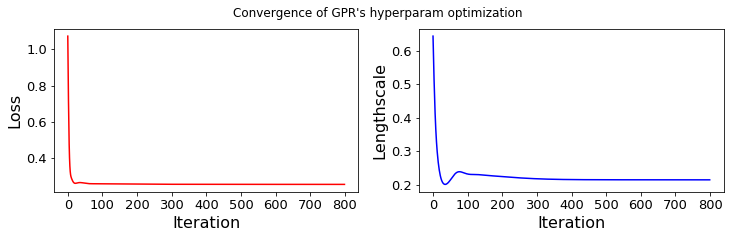

In [5]:
gpr_=gpr(xTrain=xTrain[:,None],yTrain=yTrain[:,None],noiseV=noiseSdev,
         xTest=xTest[:,None],gprOpts=gprOpts)
post_f=gpr_.post_f
post_obs=gpr_.post_y

Plot the GPR, training data, a sample from the posterior of the GPR:

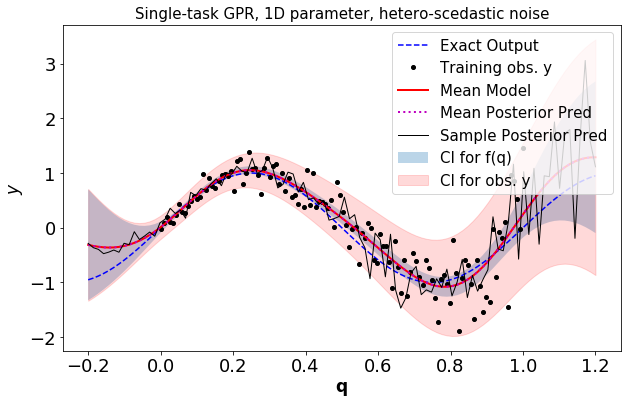

In [6]:
fExTest=fEx(xTest)  #exact model response
pltOpts={'title':'Single-task GPR, 1D parameter, %s-scedastic noise'%noiseType}
gprPlot(pltOpts).torch1d(post_f,post_obs,xTrain,yTrain,xTest,fExTest)

### Example 2: GPR over a 2D parameter space

Consider $\mathbf{q}\in\mathbb{Q}\subset \mathbb{R}^2$. The aim is to construct a GPR given a set of noisy training samples. In particular, we would like to observe the difference between the homoscedastic and heteroscedastic noises. 

First, we need a set of functions for generating synthetic training data. The simulator can be any of the existing models in `analyticTestFuncs.fEx2D`. 

In [7]:
def plot_trainData(n,fSamples,noiseSdev,yTrain):
    """Plot the noisy training data which are used in GPR"""
    plt.figure(figsize=(10,5))
    x_=np.zeros(n)
    for i in range(n):
        x_[i]=i+1
    for i in range(500):  #only for plottig possible realizations
        noise_=noiseSdev*np.random.randn(n)
        plt.plot(x_,fSamples+noise_,'.',color='steelblue',alpha=0.4,markersize=1)
    plt.errorbar(x_,fSamples,yerr=1.96*abs(noiseSdev),ls='none',capsize=5,ecolor='k',
            elinewidth=4,label=r'$95\%$ CI in Obs.')
    plt.plot(x_,fSamples,'o' ,markersize=6,markerfacecolor='lime',
             markeredgecolor='salmon',label='Mean Observation')
    plt.plot(x_,yTrain ,'xr' ,markersize=6,label='Sample Observation')
    plt.legend(loc='best',fontsize=15)
    plt.ylabel('QoI',fontsize=17)
    plt.xlabel('Simulation Index',fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    plt.title('Training data with associated confidence')
    plt.show()

def trainDataGen(p,sampleType,n,qBound,fExName,noiseType):
    """Generate Training Data"""
    #  (a) xTrain 
    if sampleType=='grid': 
       nSamp=n[0]*n[1]
       gridList=[]
       for i in range(p):    
           grid_=np.linspace(qBound[i][0],qBound[i][1],n[i])
           gridList.append(grid_)
       xTrain=reshaper.vecs2grid(gridList)
    elif sampleType=='random': 
         nSamp=n     #number of random samples   
         xTrain=sampling.LHS_sampling(n,qBound)
    #  (b) Observation noise           
    noiseSdev=noiseGen(nSamp,noiseType,xTrain,fExName)
    #  (c) Training response
    yTrain=analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp').val
    yTrain_noiseFree=yTrain
    yTrain=yTrain_noiseFree+noiseSdev*np.random.randn(nSamp)
    return xTrain,yTrain,noiseSdev,yTrain_noiseFree

def noiseGen(n,noiseType,xTrain,fExName):
    """
    Generate a 1D numpy array of standard deviations of the observation noise
    """
    if noiseType=='homo':
       sd=0.2   #(Note: non-zero, to avoid instabilities)
       sdV=sd*np.ones(n)
    elif noiseType=='hetero':       
       sdV=0.1*(analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp').val+0.001)
    return sdV

In the following settings, we can choose different model functions as the simulator, different types of sampling methods, different types of observation noise (homoscedastic or heteroscedastic), and etc.

In [8]:
qBound=[[-2,2],[-2,2]]   #Admissible range of parameters
fExName='type1'          #Type of simulator in analyticTestFuncs.fEx2D
                         #'type1', 'type2', 'type3', 'Rosenbrock'
sampleType='random'      #'random' or 'grid': type of training samples
if sampleType=='grid':
   n=[9,9]               #number of training samples in each input dimension
elif sampleType=='random':
   n=100                 #total number of training samples drawn randomly
noiseType='hetero'       #noise type: 'homo'=homoscedastic, 'hetero'=heterscedastic
#options for GPR
nIter_=1500        #number of iterations in optimization of GPR hyperparameters
lr_   =0.1         #learning rate in the optimization of the hyperparameters
convPlot_=True     #plot convergence of optimization of GPR hyperparameters
nTest=[31,30]      #number of test points in each parameter dimension

Generate training data and plot the uncertainty in the observations

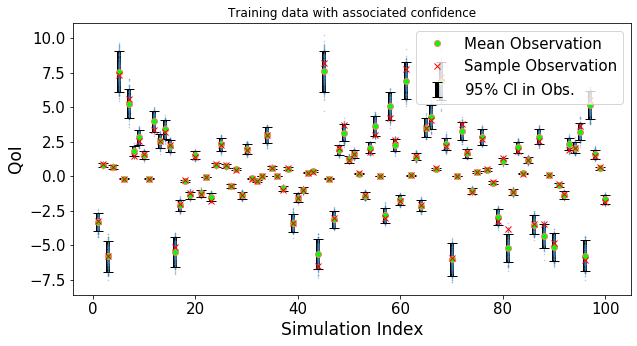

In [9]:
#(0) Assemble the gprOpts dict
gprOpts={'nIter':nIter_,'lr':lr_,'convPlot':convPlot_}
#(1) Generate training data
p=len(qBound)    #dimension of the input
xTrain,yTrain,noiseSdev,yTrain_noiseFree=trainDataGen(p,sampleType,n,qBound,fExName,noiseType)
nSamp=yTrain.shape[0]
plot_trainData(nSamp,yTrain_noiseFree,noiseSdev,yTrain)

Generate test samples

In [10]:
xTestList=[]
for i in range(p):        
    grid_=np.linspace(qBound[i][0],qBound[i][1],nTest[i])
    xTestList.append(grid_)
xTest=reshaper.vecs2grid(xTestList)

Construct the GPR and make predictions at the test samples

...... GPR-hyperparameters Optimization, iter 100/1500 - loss: 0.840  lengthscales=0.999 0.905 
...... GPR-hyperparameters Optimization, iter 200/1500 - loss: 0.828  lengthscales=1.066 0.969 
...... GPR-hyperparameters Optimization, iter 300/1500 - loss: 0.824  lengthscales=1.106 1.007 
...... GPR-hyperparameters Optimization, iter 400/1500 - loss: 0.823  lengthscales=1.133 1.033 
...... GPR-hyperparameters Optimization, iter 500/1500 - loss: 0.822  lengthscales=1.153 1.052 
...... GPR-hyperparameters Optimization, iter 600/1500 - loss: 0.821  lengthscales=1.168 1.067 
...... GPR-hyperparameters Optimization, iter 700/1500 - loss: 0.821  lengthscales=1.180 1.078 
...... GPR-hyperparameters Optimization, iter 800/1500 - loss: 0.821  lengthscales=1.189 1.087 
...... GPR-hyperparameters Optimization, iter 900/1500 - loss: 0.820  lengthscales=1.197 1.095 
...... GPR-hyperparameters Optimization, iter 1000/1500 - loss: 0.820  lengthscales=1.203 1.100 
...... GPR-hyperparameters Optimization

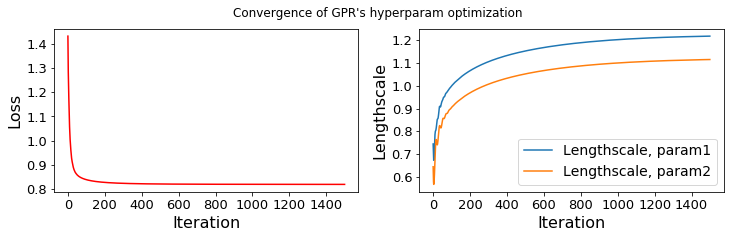

In [11]:
gpr_=gpr(xTrain,yTrain[:,None],noiseSdev,xTest,gprOpts)
post_f=gpr_.post_f
post_obs=gpr_.post_y

In [12]:
#Predicted mean and variance of the posteriors at the test grid    
fP_=gprPost(post_f,nTest)
fP_.torchPost()
post_f_mean=fP_.mean
post_f_sdev=fP_.sdev
obsP_=gprPost(post_obs,nTest)
obsP_.torchPost()
post_obs_mean=obsP_.mean
post_obs_sdev=obsP_.sdev

We can plot the contours of the mean and standard-deviation of the posterior and posterior predictive of the resulting GPR in the admissible space of $\mathbb{Q}_1\bigotimes\mathbb{Q}_2$:

No handles with labels found to put in legend.


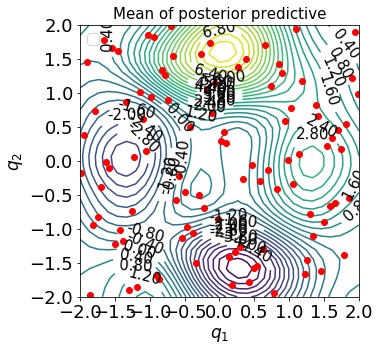

In [13]:
pltOpts={'title':'Mean of posterior predictive','xlab':r'$q_1$','ylab':r'$q_2$'}
gprPlot(pltOpts).torch2d_2dcont(xTrain,xTestList,post_obs_mean) 

No handles with labels found to put in legend.


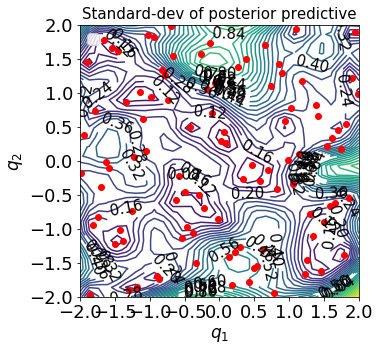

In [14]:
pltOpts={'title':'Standard-dev of posterior predictive','xlab':r'$q_1$','ylab':r'$q_2$'}
gprPlot(pltOpts).torch2d_2dcont(xTrain,xTestList,post_obs_sdev) 

We can also make a 3D plot, see below. The colored surface represents the mean of the posterior and the red and blue mesh surfaces respectively show the upper and lower 95\% confidence intervals.

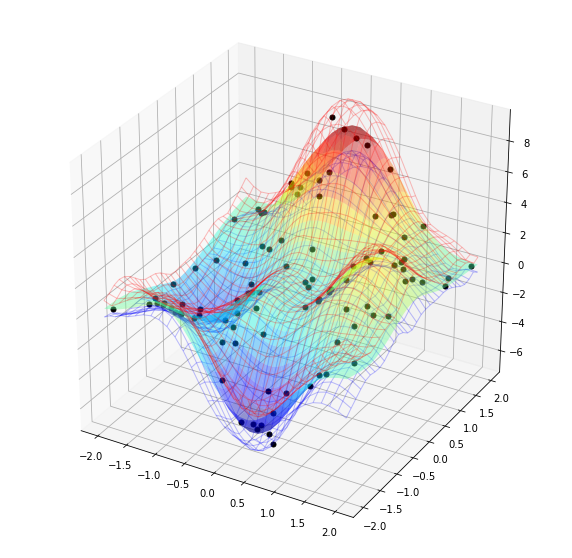

In [15]:
gprPlot().torch2d_3dSurf(xTrain,yTrain,xTestList,post_obs)